In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import polars as pl

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
class CONFIG:
    seed = 42
    target_col = "responder_6"
    feature_cols = ["symbol_id", "time_id"] \
        + [f"feature_{idx:02d}" for idx in range(79)] \
        + [f"responder_{idx}_lag_1" for idx in range(9)]
    
train = pl.scan_parquet("/kaggle/input/js24-preprocessing-create-lags/training.parquet").collect().to_pandas()
valid = pl.scan_parquet("/kaggle/input/js24-preprocessing-create-lags/validation.parquet").collect().to_pandas()
train = pd.concat([train, valid]).reset_index(drop=True)

In [3]:
from xgboost import XGBRegressor


def get_model(seed):
    # XGBoost parameters
    XGB_Params = {
        'learning_rate': 0.05,
        'max_depth': 6,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 1,
        'reg_lambda': 5,
        'random_state': seed,
        'tree_method': 'gpu_hist',
        'n_gpus;': 1,
    }
    
    XGB_Model = XGBRegressor(**XGB_Params)
    return XGB_Model

X_train = train[ CONFIG.feature_cols ]
y_train = train[ CONFIG.target_col ]
w_train = train[ "weight" ]
X_valid = valid[ CONFIG.feature_cols ]
y_valid = valid[ CONFIG.target_col ]
w_valid = valid[ "weight" ]

X_train.shape, y_train.shape, w_train.shape, X_valid.shape, y_valid.shape, w_valid.shape

((22104280, 90),
 (22104280,),
 (22104280,),
 (1082224, 90),
 (1082224,),
 (1082224,))

In [4]:
model = get_model(CONFIG.seed)
model.fit( X_train, y_train, sample_weight=w_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_gpus;=1, n_jobs=None,
             num_parallel_tree=None, ...)

In [5]:
import numpy as np
from sklearn.base import r2_score


y_pred_train1 = model.predict(X_train.iloc[:X_train.shape[0]//2])
y_pred_train2 = model.predict(X_train.iloc[X_train.shape[0]//2:])
train_score = r2_score(y_train, np.concatenate([y_pred_train1, y_pred_train2], axis=0), sample_weight=w_train)
train_score

0.03261685371398926

In [6]:
y_pred_valid = model.predict(X_valid)
valid_score = r2_score(y_valid, y_pred_valid, sample_weight=w_valid )
valid_score

0.01171940565109253

symbol_id = 0, y_means = -0.00098
symbol_id = 1, y_means = -0.00341
symbol_id = 2, y_means = -0.00397
symbol_id = 3, y_means = 0.00723
symbol_id = 4, y_means = 0.01000
symbol_id = 5, y_means = -0.00063
symbol_id = 6, y_means = 0.00344
symbol_id = 7, y_means = 0.00040
symbol_id = 8, y_means = 0.00008
symbol_id = 9, y_means = -0.03597
symbol_id = 10, y_means = 0.00631
symbol_id = 11, y_means = 0.00323
symbol_id = 12, y_means = -0.00015
symbol_id = 13, y_means = -0.01423
symbol_id = 14, y_means = -0.00069
symbol_id = 15, y_means = 0.00938
symbol_id = 16, y_means = 0.00351
symbol_id = 17, y_means = 0.00097
symbol_id = 18, y_means = 0.00169
symbol_id = 19, y_means = 0.01435
symbol_id = 20, y_means = 0.00564
symbol_id = 21, y_means = 0.00550
symbol_id = 22, y_means = -0.00096
symbol_id = 23, y_means = 0.01218
symbol_id = 24, y_means = -0.00468
symbol_id = 25, y_means = -0.01868
symbol_id = 26, y_means = -0.00052
symbol_id = 27, y_means = -0.00559
symbol_id = 28, y_means = -0.00516
symbol_id 

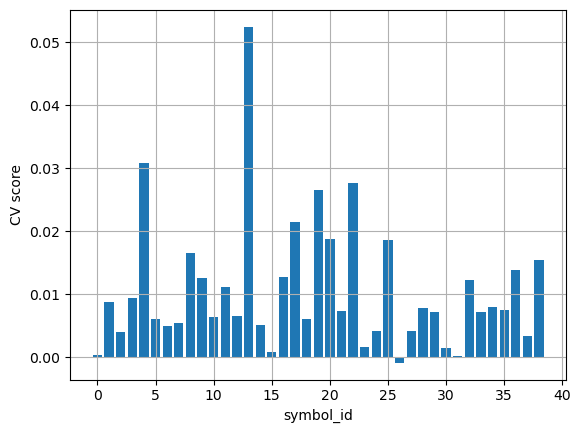

In [7]:
from matplotlib import pyplot as plt


y_means = { symbol_id : -1 for symbol_id in range(39) }
for symbol_id, gdf in train[["symbol_id", CONFIG.target_col]].groupby("symbol_id"):
    y_mean = gdf[ CONFIG.target_col ].mean()
    y_means[symbol_id] = y_mean
    print(f"symbol_id = {symbol_id}, y_means = {y_mean:.5f}")
    
cv_detail = { symbol_id : 0 for symbol_id in range(39) }
for symbol_id, gdf in valid.groupby("symbol_id"):
    X_valid = gdf[ CONFIG.feature_cols ]
    y_valid = gdf[ CONFIG.target_col ]
    w_valid = gdf[ "weight" ]
    y_pred_valid = model.predict(X_valid)
    score = r2_score(y_valid, y_pred_valid, sample_weight=w_valid )
    cv_detail[symbol_id] = score
    
    print(f"symbol_id = {symbol_id}, score = {score:.5f}")
    
sids = list(cv_detail.keys())
plt.bar(sids, [cv_detail[sid] for sid in sids])
plt.grid()
plt.xlabel("symbol_id")
plt.ylabel("CV score")
plt.show()

In [12]:
import os
import dill

result = {
    "model" : model,
    "cv" : valid_score,
    "cv_detail" : cv_detail,
    "y_mean" : y_means,
}
os.makedirs('./output', exist_ok=True)
with open("./output/xgb_result.dill", "wb") as fp:
    dill.dump(result, fp)